## <center>  Notebook S04. Single Mobility Classification </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 


This notebook demonstrates how to the software can be used to find the true size distribution of monodispersed mobility selected particles.   <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

### Problem description
Figure 1 shows a schematic instrument setup with an array of detectors. Here the DMA is operated in classifier mode and set to a single voltage. The mobility classified particles are then passed to one or more detectors. One applications of this approach is the calibration of detetection efficiency of an instrument or technique. For example, size selected particles are fed to a particle into liquid sampler or an aerosol mass spectrometer. The measured solute mass is then compared to mass generated by the DMA.  Another application is the determination of physical property. Examples are the measurement of bulk light scattering (nephelometer as detector) or ice nucleating efficiency (ice nucleation instrument as detector) for monodisperse particles of known composition. In the latter two examples, the physical property is proportional to surface area. This notebook demonstrates how to evaluate the selected size distribution and the derivation of moments of these distributions. 

<img src="Figures/nbs4_f01.png" width="400"> <br>
<b> Figure 1. </b> Schematic of DMA with an array of detectors. <br>


## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, ProgressMeter, DataFrames, DifferentialMobilityAnalyzers
using Printf,LinearAlgebra
plotlyjs(); 

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Setup DMA

In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
DMAtype = :cylindrical                           # DMA form factor
m = 3                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,DMAtype) # Specify DMA with negative polarity
bins,z₁,z₂ = 512, dtoz(Λ,1000e-9), dtoz(Λ,10e-9) # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);  

## Block 3. Select Diameter
Select a single mobility diameter. Then compute the the electrical mobility and diameters for +1, + 2, +3 charges.

In [3]:
Dm = 100.0                   # Size select 100 nm mobility diameter
zˢ = dtoz(Λ, Dm*1e-9);       # Compute corresponding electrical mobility
Dp = map(k->ztod(Λ,k,zˢ), 1:Λ.m)
@printf("The +1, +2, and +3 selected diameters are %3.0f, %3.0f, and %3.0f nm\n", Dp[1],Dp[2],Dp[3])

The +1, +2, and +3 selected diameters are 100, 151, and 195 nm


## Block 4 . Define Size Selection Convolution Functions
Transmission through the DMA for a single mobility is given by (Notebook S2).

In [4]:
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp);  # DMA Transmission (Notebook 2)

## Block 5. Compute Monodisperse Size and Mobility Distributions
The size distribution of the mobility selected aerosol is estimated from the actual size distribution that can be either a generated from a function or from actual data.

In [5]:
Ax = [[600., 60., 1.9], [900., 210., 1.9]]  # [[Nt1,Dg1,σ1],[Nt1,Dg1,σ1], ....]
𝕟ᶜⁿ = DMALognormalDistribution(Ax, δ);      # Returns the size distribution 
ℕ = map(k -> T(zˢ,k,Λ,δ)*𝕟ᶜⁿ,1:Λ.m)                                # ℕ[k] : Mob. size distribution +k charges
𝕄 = map(k -> (ztod(Λ,1,zˢ)/ztod(Λ,k,zˢ))⋅(T(zˢ,k,Λ,δ)*𝕟ᶜⁿ),1:Λ.m) # 𝕄[k] : App. Mob. distribution +k charges 
𝕟ₜ, 𝕞ₜ = sum(ℕ), sum(𝕄);                                          # 𝕟ₜ,𝕞ₜ: Reconstructed total distribution 

## Block 6. Visualize Results

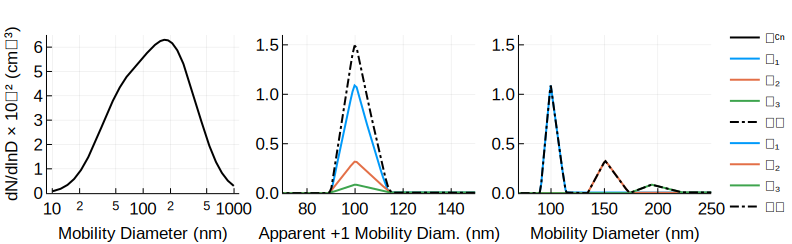

In [6]:
figure("Nimbus Sans L", 2, 5.5, 1.7, 8)

# Get a list of colors from the theme palette
p = Plots.get_color_palette(:auto, default(:bgcolor), 100)

# Size distribution
pre = 1e-2
p1 = plot(𝕟ᶜⁿ.Dp, pre*𝕟ᶜⁿ.S, xaxis = :log10, xticks = [10, 100, 1000], ylabel = "dN/dlnD × 10⁻² (cm⁻³)", 
    label = "𝕟ᶜⁿ", color = :black,left_margin = 20px, xlabel = "Mobility Diameter (nm)",
    ylim = (0,6.5))

# Mobility distribution
p2 = plot(𝕄[1].Dp,pre*𝕄[1].S,  xlim = (70,150), label = "𝕄₁", xtick = [80,100,120, 140],
     ytick = [0,0.5,1, 1.5], ylim = (0,1.6), xlabel = "Apparent +1 Mobility Diam. (nm)")
p2 = plot!(𝕄[2].Dp,pre*𝕄[2].S, label = "𝕄₂")   
p3 = plot!(𝕄[3].Dp,pre*𝕄[3].S, label = "𝕄₃")   
p2 = plot!(𝕞ₜ.Dp,pre*𝕞ₜ.S, ls = :dashdot, color = :black, label = "𝕞ₜ")   

# Size distribution
p3 = plot(ℕ[1].Dp,pre*ℕ[1].S, xlim = (70,250), label = "ℕ₁", ytick = [0,0.5,1,1.5],
     xlabel = "Mobility Diameter (nm)", ylim = (0,1.6))
p3 = plot!(ℕ[2].Dp,pre*ℕ[2].S, label = "ℕ₂")   
p3 = plot!(ℕ[3].Dp,pre*ℕ[3].S, label = "ℕ₃")   
p3 = plot!(𝕟ₜ.Dp,pre*𝕟ₜ.S, ls = :dashdot, color = :black, label = "𝕟ₜ", right_margin = 15px)   

plot(p1,p2,p3, layout = grid(1,3), legend=:right, top_margin = 18px, lw = 2, fmt = :svg)

<b> Figure 2. </b> Left: assumed bimodal lognormal size distribution. Middle: monodisperse mobility size distribution. Dashed line is total number concentration. Blue, organge, and green lines represent the contribution of +1, +2, and +3 charges to the size selection. 

## Block 7. Moments
When computing moments of the distribution (e.g. surface area and volume), the moments will be underestimated when using the mobility diamter as a basis. True surface area and volume will be larger due to the larger diameter of +2 and +3 charged particles. From experimental data, the quick and naïve way to compute surface area and volume are 
<center> $A = \pi D_m^2 N_t$ </center> 
<center> $V = \frac{\pi}{6} D_m^3 N_t$ </center> 
where $A$ and $V$ are the volume concentration, $D_m$ is the selected diameter, and $N_t$ is the total number concentration. The table below shows how accurate this approximation is for the example shown in Figure 1.

In [7]:
units = ["","cm⁻³","μm² cm⁻³","μm³ cm⁻³","","cm⁻³","μm² cm⁻³","μm³ cm⁻³"]
Apre = π*(𝕞ₜ.Dp*1e-3).^2       # prefactor in μm² cm⁻³
Vpre = (π*(𝕞ₜ.Dp*1e-3).^3)/6   # prefactor in μm³ cm⁻³

Label = [units[1], "+1", "+2", "+3", "Total", "Approximation"]
Nₘₒ = [units[2]; round.([sum(𝕄[1].N), sum(𝕄[2].N), sum(𝕄[3].N), sum(𝕞ₜ.N), NaN], digits=1)]
Aₘₒ = [units[3]; round.([sum(Apre.*𝕄[1].N), sum(Apre.*𝕄[2].N), sum(Apre.*𝕄[3].N), 
                sum(Apre.*𝕞ₜ.N), π*(Dm*1e-3)^2*sum(𝕞ₜ.N)],digits=2)]
Vₘₒ = [units[4]; round.([sum(Vpre.*𝕄[1].N), sum(Vpre.*𝕄[2].N), sum(Vpre.*𝕄[3].N), 
                        sum(Vpre.*𝕞ₜ.N), π*(Dm*1e-3)^3*sum(𝕞ₜ.N)/6],digits=4)]

Blank = ["","","","","",""]

Ap = [π*(ℕ[1].Dp*1e-3).^2, π*(ℕ[2].Dp*1e-3).^2, π*(ℕ[3].Dp*1e-3).^2, π*(𝕟ₜ.Dp*1e-3).^2] # prefactor μm² cm⁻³
Vp = [(π*(ℕ[1].Dp*1e-3).^3)/6, (π*(ℕ[2].Dp*1e-3).^3)/6, (π*(ℕ[3].Dp*1e-3).^3)/6, (π*(𝕟ₜ.Dp*1e-3).^3)/6] 

Nₜᵣᵤₑ = [units[6]; round.([sum(ℕ[1].N), sum(ℕ[2].N), sum(ℕ[3].N), sum(𝕟ₜ.N), NaN],digits=1)]
Aₜᵣᵤₑ = [units[7]; round.([sum(Ap[1].*ℕ[1].N), sum(Ap[2].*ℕ[2].N), sum(Ap[3].*ℕ[3].N), 
                           sum(Ap[4].*𝕟ₜ.N), π*(Dm*1e-3)^2*sum(𝕟ₜ.N)],digits=2)]
Vₜᵣᵤₑ = [units[8]; round.([sum(Vp[1].*ℕ[1].N), sum(Vp[1].*ℕ[2].N), sum(Vp[3].*ℕ[3].N), 
                           sum(Vp[4].*𝕟ₜ.N), π*(Dm*1e-3)^3*sum(𝕟ₜ.N)/6],digits=4)]

DataFrame(Label=Label, Nₘₒ=Nₘₒ, Aₘₒ=Aₘₒ, Vₘₒ=Vₘₒ, Blank=Blank, Nₜᵣᵤₑ=Nₜᵣᵤₑ, Aₜᵣᵤₑ=Aₜᵣᵤₑ, Vₜᵣᵤₑ=Vₜᵣᵤₑ)

,Label,Nₘₒ,Aₘₒ,Vₘₒ,Blank,Nₜᵣᵤₑ,Aₜᵣᵤₑ,Vₜᵣᵤₑ
,String,Any,Any,Any,String,Any,Any,Any
1,,cm⁻³,μm² cm⁻³,μm³ cm⁻³,,cm⁻³,μm² cm⁻³,μm³ cm⁻³
2,+1,13.2,0.42,0.0072,,13.2,0.42,0.0072
3,+2,4.2,0.13,0.0023,,4.2,0.3,0.0078
4,+3,1.2,0.04,0.0006,,1.2,0.14,0.0047
5,Total,18.6,0.6,0.0101,,18.6,0.87,0.0197
6,Approximation,NaN,0.58,0.0097,,NaN,0.58,0.0097


<b> Table 1. </b> Computed number concentration, surface area, and volume from the distributions in Figure 1, middle panel (mobility diameter distributions) and right panel true diameter distributions. For this case, the true surface area and volume are ~50% and ~100% larger than the naive approximation. 

### Generalization
For a given selection mobility DMA defined by Λ,δ, and input size distribution 𝕟ᶜⁿ, the mapping between mobility Zs and number, surface area and volume distributions is
```julia
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp)
Nz = zˢ -> Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m)
Az = zˢ -> (π.*(𝕟ᶜⁿ.Dp .* 1e-3).^2) * (Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m))
Vz = zˢ -> (π/6.0*(𝕟ᶜⁿ.Dp*1e-3).^3) * (Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m))
```
where the diameter is in nm and the output are SizeDistributions in cm⁻³, μm² cm⁻³, and μm³ cm⁻³ for number surface area and volume distributions. The use of the function Σ(f, n) is as in Notebook S2. An example is shown below. The next block defines a new DMA structure with charges up to +6.

In [8]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)  # Specify DMA with negative polarity
bins,z₁,z₂ = 512, dtoz(Λ,1000e-9), dtoz(Λ,10e-9) # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);  

And an example for some distribution

In [9]:
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp)
Nz = zˢ -> Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m)
Az = zˢ -> (π.*(𝕟ᶜⁿ.Dp .* 1e-3).^2) * (Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m))
Vz = zˢ -> (π/6.0*(𝕟ᶜⁿ.Dp*1e-3).^3) * (Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m));

In [10]:
Dm = 100                     # 100 nm size selection
Dp = map(k->ztod(Λ,k,zˢ), 1:Λ.m)
zˢ = dtoz(Λ, Dm*1e-9);       # Compute corresponding electrical mobility
𝕟ᶜⁿ = DMALognormalDistribution([[600., 60., 1.9], [900., 210., 1.9]], δ);   # The size distribution 
𝕟ᴺ = Nz(zˢ)            # Number distribution
𝕟ᴬ = Az(zˢ)            # Area distribution
𝕟ⱽ = Vz(zˢ);           # Volume distribution

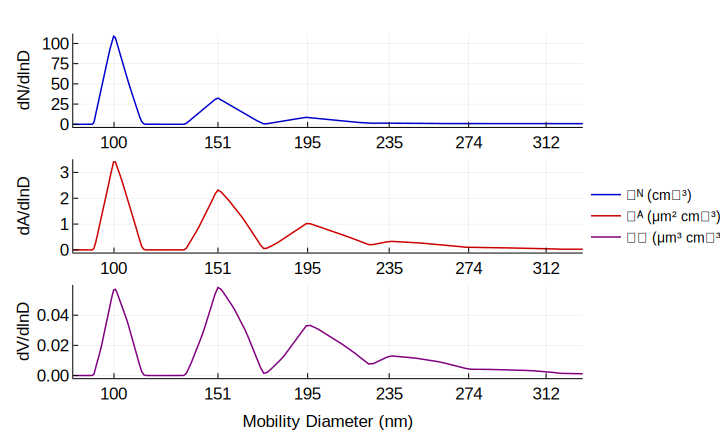

In [11]:
figure("Nimbus Sans L", 2, 5, 3, 8)

p1 = plot(𝕟ᴺ.Dp, 𝕟ᴺ.S, xticks = round.(Dp,digits=0), ylabel = "dN/dlnD", color = RGBA(0,0,0.8,1),
    label = "𝕟ᴺ (cm⁻³)", left_margin = 20px, xlim = (80,330), lw = 1.5)

p2 = plot(𝕟ᴬ.Dp, 𝕟ᴬ.S, xticks = round.(Dp,digits=0), ylabel = "dA/dlnD", 
    label = "𝕟ᴬ (μm² cm⁻³)", left_margin = 20px,  color = RGBA(0.8,0,0,1),
 xlim = (80,330), lw = 1.5)

p3 = plot(𝕟ⱽ.Dp, 𝕟ⱽ.S, xticks = round.(Dp,digits=0), ylabel = "dV/dlnD", 
    label = "𝕟ⱽ (μm³ cm⁻³)", left_margin = 20px, xlabel = "Mobility Diameter (nm)", 
    color = RGBA(0.5,0,0.5,1), xlim = (80,330), yticks = [0, 0.02, 0.04], lw = 1.5)

plot(p1,p2,p3, layout = grid(3,1), legend=:right, top_margin = 15px, fmt = :svg)

<b> Figure 3 </b> Number, surface area, and volume distributions of a single selected mobility, where calculations are carried out up to +6 charges. The tickmarks/gridlines correspond to the selected +1, +2, +3, +4, +5, and +6 diameter. 

Esimate the error in surface area and volume relative to the naive estimate based on selected diameter.

In [12]:
ErrorA = sum(𝕟ᴬ.N)./(π*(Dm*1e-3)^2*sum(𝕟ᴺ.N))
ErrorV = sum(𝕟ⱽ.N)./(π/6*(Dm*1e-3)^3*sum(𝕟ᴺ.N))
println(round.([ErrorA,ErrorV],digits=2))

[1.58, 2.27]


Note that these are slightly larger than in Table 1, because here +4, +5, and +6 charged particles are also included. To further generalize, a plot of error in A and V relative to the naive estimate is generated.

In [13]:
N = map(zˢ->Nz(zˢ), δ.Z);
A = map(zˢ->Az(zˢ), δ.Z);
V = map(zˢ->Vz(zˢ), δ.Z);

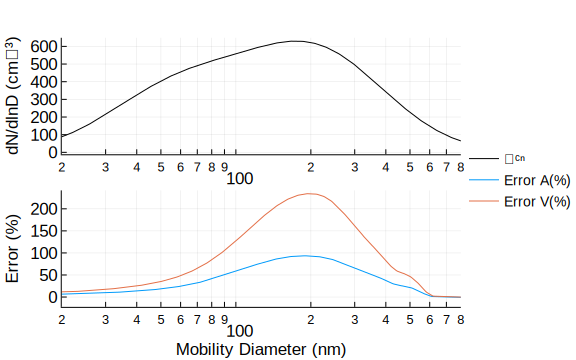

In [14]:
figure("Nimbus Sans L", 2, 4, 2.5, 8)
ErrorA = map(i->sum(A[i].N)./(π*(δ.Dp[i]*1e-3)^2*sum(N[i].N)),1:bins)
ErrorV = map(i->sum(V[i].N)./(π/6*(δ.Dp[i]*1e-3)^3*sum(N[i].N)),1:bins)
p1 = plot(𝕟ᶜⁿ.Dp, 𝕟ᶜⁿ.S, xaxis = :log10, color = :black, label = "𝕟ᶜⁿ", ylabel = "dN/dlnD (cm⁻³)")
p2 = plot(δ.Dp, 100 .* ErrorA .- 100, xaxis = :log10, label = "Error A(%)", 
          xlabel = "Mobility Diameter (nm)", ylabel = "Error (%)")
p2 = plot!(δ.Dp, 100 .* ErrorV .- 100, xaxis = :log10, label = "Error V(%)")

plot(p1,p2, layout = grid(2,1), legend=:right, top_margin = 20px, left_margin = 20px, 
    xlim = (20,800), fmt = :svg)

<b> Figure 4. </b> Size dependence of the error in surface area and volume relative to the naïve approximation. The error is larger for larger particles due to the higher prevalance of multiply charged particles. However, to the right of the peak of the size distribution, the abundundance of multiply charged particles is supressed (since there are fewer particles). Consequently for 700 nm the error vanishes. Note that the distribution cuts off at ~1000 nm, and thus by definition the concentration of multiply charged particles for large sizes is zero.

## Summary and Conclusions
The true number, surface area, and volume distributions for a single mobility size selection are readily estimated using a simple set of functions

```julia
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp)
Nz = zˢ -> Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m)
Az = zˢ -> (π.*(𝕟ᶜⁿ.Dp .* 1e-3).^2) * (Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m))
Vz = zˢ -> (π/6.0*(𝕟ᶜⁿ.Dp*1e-3).^3) * (Σ(k->T(zˢ,k,Λ,δ)*𝕟ᶜⁿ, Λ.m))
```

From these the total number, surface area, and volume concentrations can be directly obtained. The error in estimated number concentration from a simple approximation based on selected mobility size and number concentration is up to 200% for volume concentration and up to 100% for surface area concentration for the example distribution shown. The error will depend on the input size distribution and need to be computed on a case-by-case basis.